<a href="https://colab.research.google.com/github/Evangelistabv/Proyecto-ml/blob/main/Bosques_Aleatorios.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Proyecto Machine learning
A partir de la base de datos,crear una tabla con los clientes que tengan máximo un producto e indicar en una variable qué otro
se le debería ofrecer al cliente de acuerdo con su perfil


##Visualización y limpieza de datos


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
archivo = '/content/informe.xlsx'
datos= pd.read_excel(archivo, sheet_name='info')
datos.head()

,CLIENTE,EDAD,GENERO,INGRESOS,FECHA_DE_ALTA,SCORE_BURO,NOMINA,TDC,CRED_HIPOT,CRED_AUTO
0,3001,40,H,6350,18/03/12,575.0,1,1,1,0
1,3002,30,H,29153,22/11/10,523.0,1,1,0,1
2,3003,32,M,19436,21/01/08,491.0,1,1,0,1
3,3006,48,H,22777,27/02/19,472.0,1,0,0,0
4,3008,54,H,17063,19/06/10,572.0,0,1,0,0


In [ ]:
valores_nulos_por_columna = datos.isnull().sum()

print(valores_nulos_por_columna)

CLIENTE            0
EDAD               0
GENERO             0
INGRESOS           0
FECHA_DE_ALTA      0
SCORE_BURO       950
NOMINA             0
TDC                0
CRED_HIPOT         0
CRED_AUTO          0
dtype: int64


In [ ]:
datos = datos.dropna(subset=['SCORE_BURO']) #eliminamos las filas con valores nulos para no afectar el análisis
datos['GENERO'] = np.where(datos['GENERO'] == 'H', 1, 0) #Esta variable categorica la transformamos en booleana para manejarla adecuadamente
datos = datos.drop(columns = 'FECHA_DE_ALTA') #eliminamos la columna fecha de alta al no ver que sea una variable que pueda aportar
datos.head()

<ipython-input-50-4ce26044127a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  datos['GENERO'] = np.where(datos['GENERO'] == 'H', 1, 0) #Esta variable categorica la transformamos en booleana para manejarla adecuadamente


,CLIENTE,EDAD,GENERO,INGRESOS,SCORE_BURO,NOMINA,TDC,CRED_HIPOT,CRED_AUTO
0,3001,40,1,6350,575.0,1,1,1,0
1,3002,30,1,29153,523.0,1,1,0,1
2,3003,32,0,19436,491.0,1,1,0,1
3,3006,48,1,22777,472.0,1,0,0,0
4,3008,54,1,17063,572.0,0,1,0,0


Lo que se nos pide es una variable que indique qué producto se le debería ofrecer al cliente dado su perfil,echando un vistazo a las variables observamos que es posible clasificar el perfil según las características edad,género,ingresos,score_buro y los productos que posee. Para poder clasificar el perfil usaremos un modelo de machine learning llamado Random forest o bosques aleatorios que parece ser el más adecuado a primera vista.

La idea consiste en obtener los registros de los clientes que poseen el producto 'A'. Después separamos estos registros en dos grupos,el grupo A_1 que contendrá a los clientes con el producto A y otro u otros productos tambien,y el grupo A_2 que serán los clientes que únicamente poseen el producto A.

Primero trabajaremos con el producto 'NÓMINA' como el producto A

In [ ]:
datos_nomina = datos.loc[(datos['NOMINA'] == 1)
                            & ((datos['TDC'] + datos['CRED_AUTO']
                            + datos['CRED_HIPOT']) > 0)] #obtemos nuestro grupo A_1
                            # lo almacenamos en la variable datos_nomina


datos_perfil = datos.loc[((datos['TDC'] + datos['CRED_AUTO']
                          + datos['CRED_HIPOT']) == 0) & (datos['NOMINA'] == 1)]
                          #obtenemos nuestra variabe A_2 y lo almacenamos en datos_perfil
datos_nomina.head()

,CLIENTE,EDAD,GENERO,INGRESOS,SCORE_BURO,NOMINA,TDC,CRED_HIPOT,CRED_AUTO
0,3001,40,1,6350,575.0,1,1,1,0
1,3002,30,1,29153,523.0,1,1,0,1
2,3003,32,0,19436,491.0,1,1,0,1
12,3023,39,1,5741,596.0,1,1,0,1
13,3026,20,0,15958,613.0,1,0,0,1


In [ ]:
datos_perfil.head()

,CLIENTE,EDAD,GENERO,INGRESOS,SCORE_BURO,NOMINA,TDC,CRED_HIPOT,CRED_AUTO
3,3006,48,1,22777,472.0,1,0,0,0
8,3016,55,0,16056,749.0,1,0,0,0
15,3029,48,0,5133,661.0,1,0,0,0
18,3034,49,0,17971,456.0,1,0,0,0
25,3046,55,0,27696,522.0,1,0,0,0


Lo anterior se hizo con el fin de obtener un grupo ,A_1,que será el que entrenaremos para que nuestro modelo encuentre patrones en las características (edad,género, etc.) y si tiene o no el producto B (en nuestro caso podemos observar en la tabla datos_nomina que no todos tienen el producto tdc por ejemplo). El grupo A_2 que tiene a los clientes con solo el producto A nos servirá para realizar predicciones, este grupo se le otorgara a nuestro modelo entrenado el cual asignará una probabilidad de que el cliente tenga el producto B dadas sus características.El procedimiento se repetirá para el producto C y D en nuestro caso.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

dataframeFinal = datos_perfil.drop(
    columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])#esta variable almacenará las predicciones
                                                        #y las características  del cliente
productos = ['CRED_AUTO','CRED_HIPOT','TDC']#variable auxiliar para realizar el procedimiento con cada producto

for columna in datos_nomina:
    if columna in productos:
        X = datos_nomina.drop(columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])#aqui almacenamos las características
        y = datos_nomina[columna]#almacenamos la columna del producto en turno (TDC,CRED_HIPOT,CRED_AUTO)

        X_train, X_test, y_train, y_test = train_test_split(
                                                X,
                                                y.values.reshape(-1,1),
                                                train_size   = 0.8,
                                                shuffle      = True
                                            )# dividimos nuestro conjunto,uno para entrenarlo
                                            #y otro para saber el porcentaje de aciertos de nuestro modelo entrenado
        y_train = np.ravel(y_train)#ajusta la forma de los datos para entrenarlos
        modelo_final = RandomForestClassifier(
                        oob_score    = True,
                        n_jobs       = -1,
                        n_estimators = 120,
                        max_features = 2,
                        max_depth   = 3,
                        criterion   = 'gini',
                      ).fit(X_train, y_train)#Entrenamos a nuestros datos con la funcion  RandomForestClassifier

        aciertos = modelo_final.predict(X=X_test) #realizamos las predicciones con el modelo entrenado con
                                                  #el grupo que habíamos separado para saber el %aciertos
        accuracy = accuracy_score(y_true=y_test, y_pred=aciertos, normalize=True)
        print(f"El accuracy de test para el producto {columna} es: {100 * accuracy} % \n")#imprimimos el porcentaje de aciertos

        predicciones = modelo_final.predict_proba(
            X=datos_perfil.drop(
                columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])
            ) #realizamos las predicciones para nuestro grupo A_2 asignandole una probabilidad
        dataframeFinal['Probabilidad '+columna]= predicciones[:,1] #almacenamos las predicciones del producto en turno

dataframeFinal['Producto a ofrecer'] = dataframeFinal[['Probabilidad TDC', 'Probabilidad CRED_HIPOT', 'Probabilidad CRED_AUTO']].idxmax(axis=1)
dataframeFinal['Producto a ofrecer'] = dataframeFinal.apply(lambda row: 'TDC' if row['Producto a ofrecer'] == 'Probabilidad TDC'
                                                            else('CRED_HIPOT' if row['Producto a ofrecer'] == 'Probabilidad CRED_HIPOT'
                                                            else 'CRED_AUTO'), axis=1)#columna para registrar el producto que se debe ofrecer segun su probabilidad

dataframeFinal.head()

El accuracy de test para el producto TDC es: 74.55919395465995 % 

El accuracy de test para el producto CRED_HIPOT es: 69.26952141057934 % 

El accuracy de test para el producto CRED_AUTO es: 63.72795969773299 % 



,CLIENTE,EDAD,GENERO,INGRESOS,SCORE_BURO,Probabilidad TDC,Probabilidad CRED_HIPOT,Probabilidad CRED_AUTO,Producto a ofrecer
3,3006,48,1,22777,472.0,0.816260,0.256592,0.378338,TDC
8,3016,55,0,16056,749.0,0.786174,0.255101,0.456168,TDC
15,3029,48,0,5133,661.0,0.759769,0.278416,0.446726,TDC
18,3034,49,0,17971,456.0,0.639228,0.306227,0.415316,TDC
25,3046,55,0,27696,522.0,0.816385,0.250925,0.281173,TDC


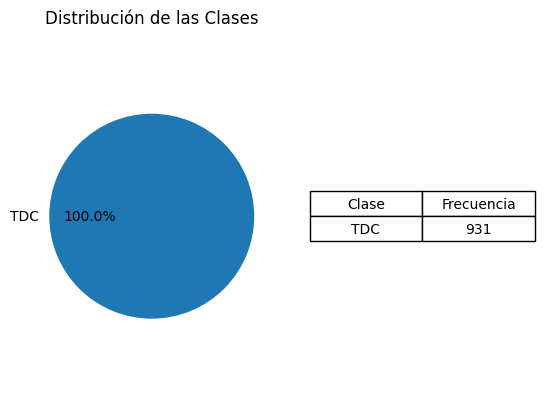

In [ ]:
contar = dataframeFinal['Producto a ofrecer'].value_counts()
# Crear el gráfico de pastel
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.pie(contar.values, labels=list(contar.keys()), autopct='%1.1f%%')
plt.axis('equal')  # Hacer que el gráfico de pastel sea circular
plt.title('Distribución de las Clases')

# Crear la tabla
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
tabla = plt.table(cellText=[[label, value] for label, value in contar.items()],
                  loc='center',
                  cellLoc='center',
                  colLabels=['Clase', 'Frecuencia'])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 1.5)  # Ajustar el tamaño de la tabla
plt.axis('off')  # Desactivar los ejes

plt.show()

nuestro modelo nos indica que deberíamos ofrecer a todos los clientes con el producto NÓMINA el producto TDC.

procedemos a realizar lo anterior con los productos restantes.

#Predicción para los clientes que tienen únicamente el producto **TDC**

In [ ]:
datos_tdc = datos.loc[(datos['TDC'] == 1)
                            & ((datos['NOMINA'] + datos['CRED_AUTO']
                            + datos['CRED_HIPOT']) > 0)] #obtemos nuestro grupo A_1
                            # lo almacenamos en la variable datos_nomina


datos_perfilTdc = datos.loc[((datos['NOMINA'] + datos['CRED_AUTO']
                          + datos['CRED_HIPOT']) == 0) & (datos['TDC'] == 1)]
                          #obtenemos nuestra variabe A_2 y lo almacenamos en datos_perfil

dataframeFinalTdc = datos_perfilTdc.drop(
    columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])#esta variable almacenará las predicciones
                                                        #y las características  del cliente
productos = ['CRED_AUTO','CRED_HIPOT','NOMINA']#variable auxiliar para realizar el procedimiento con cada producto

for columna in datos_tdc:
    if columna in productos:
        X = datos_tdc.drop(columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])#aqui almacenamos las características
        y = datos_tdc[columna]#almacenamos la columna del producto en turno (TDC,CRED_HIPOT,CRED_AUTO)

        X_train, X_test, y_train, y_test = train_test_split(
                                                X,
                                                y.values.reshape(-1,1),
                                                train_size   = 0.8,
                                                shuffle      = True
                                            )# dividimos nuestro conjunto,uno para entrenarlo
                                            #y otro para saber el porcentaje de aciertos de nuestro modelo entrenado
        y_train = np.ravel(y_train)#ajusta la forma de los datos para entrenarlos
        modelo_finalTdc = RandomForestClassifier(
                        oob_score    = True,
                        n_jobs       = -1,
                        n_estimators = 120,
                        max_features = 2,
                        max_depth   = 3,
                        criterion   = 'gini',
                      ).fit(X_train, y_train)#Entrenamos a nuestros datos con la funcion  RandomForestClassifier

        aciertos = modelo_finalTdc.predict(X=X_test) #realizamos las predicciones con el modelo entrenado con
                                                  #el grupo que habíamos separado para saber el %aciertos
        accuracy = accuracy_score(y_true=y_test, y_pred=aciertos, normalize=True)
        print(f"El accuracy de test para el producto {columna} es: {100 * accuracy} % \n")#imprimimos el porcentaje de aciertos

        predicciones = modelo_finalTdc.predict_proba(
            X=datos_perfilTdc.drop(
                columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])
            ) #realizamos las predicciones para nuestro grupo A_2 asignandole una probabilidad
        dataframeFinalTdc['Probabilidad '+columna]= predicciones[:,1] #almacenamos las predicciones del producto en turno

dataframeFinalTdc['Producto a ofrecer'] = dataframeFinalTdc[['Probabilidad NOMINA', 'Probabilidad CRED_HIPOT', 'Probabilidad CRED_AUTO']].idxmax(axis=1)
dataframeFinalTdc['Producto a ofrecer'] = dataframeFinalTdc.apply(lambda row: 'NOMINA' if row['Producto a ofrecer'] == 'Probabilidad NOMINA'
                                                            else('CRED_HIPOT' if row['Producto a ofrecer'] == 'Probabilidad CRED_HIPOT'
                                                            else 'CRED_AUTO'), axis=1)#columna para registrar el producto que se debe ofrecer segun su probabilidad

dataframeFinalTdc.head()

El accuracy de test para el producto NOMINA es: 82.40223463687151 % 

El accuracy de test para el producto CRED_HIPOT es: 76.53631284916202 % 

El accuracy de test para el producto CRED_AUTO es: 70.39106145251397 % 



,CLIENTE,EDAD,GENERO,INGRESOS,SCORE_BURO,Probabilidad NOMINA,Probabilidad CRED_HIPOT,Probabilidad CRED_AUTO,Producto a ofrecer
4,3008,54,1,17063,572.0,0.853920,0.272726,0.422063,NOMINA
6,3013,51,0,15709,495.0,0.857185,0.293586,0.426806,NOMINA
17,3032,51,1,3496,534.0,0.811313,0.329972,0.424104,NOMINA
28,3055,21,0,7868,468.0,0.843235,0.292050,0.316975,NOMINA
34,3064,54,0,16056,593.0,0.872794,0.255260,0.289515,NOMINA


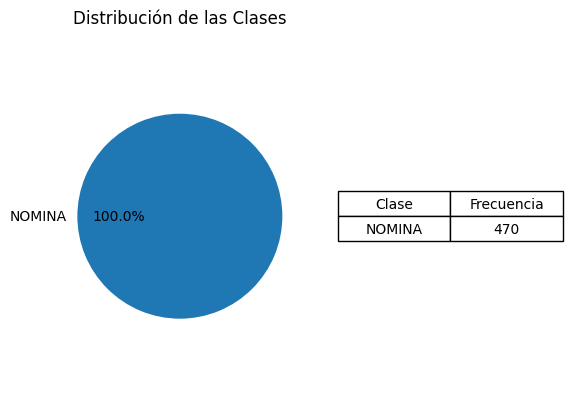

In [ ]:
contar = dataframeFinalTdc['Producto a ofrecer'].value_counts()
# Crear el gráfico de pastel
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.pie(contar.values, labels=list(contar.keys()), autopct='%1.1f%%')
plt.axis('equal')  # Hacer que el gráfico de pastel sea circular
plt.title('Distribución de las Clases')

# Crear la tabla
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
tabla = plt.table(cellText=[[label, value] for label, value in contar.items()],
                  loc='center',
                  cellLoc='center',
                  colLabels=['Clase', 'Frecuencia'])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 1.5)  # Ajustar el tamaño de la tabla
plt.axis('off')  # Desactivar los ejes

plt.show()

#Predicción para los clientes que tienen únicamente el producto **CRED_HIPOT**

In [ ]:
datos_hipot = datos.loc[(datos['CRED_HIPOT'] == 1)
                            & ((datos['NOMINA'] + datos['CRED_AUTO']
                            + datos['TDC']) > 0)] #obtemos nuestro grupo A_1
                            # lo almacenamos en la variable datos_nomina


datos_perfilhipot = datos.loc[((datos['NOMINA'] + datos['CRED_AUTO']
                          + datos['TDC']) == 0) & (datos['CRED_HIPOT'] == 1)]
                          #obtenemos nuestra variabe A_2 y lo almacenamos en datos_perfil

dataframeFinalhipot = datos_perfilhipot.drop(
    columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])#esta variable almacenará las predicciones
                                                        #y las características  del cliente
productos = ['CRED_AUTO','TDC','NOMINA']#variable auxiliar para realizar el procedimiento con cada producto

for columna in datos_hipot:
    if columna in productos:
        X = datos_hipot.drop(columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])#aqui almacenamos las características
        y = datos_hipot[columna]#almacenamos la columna del producto en turno (TDC,CRED_HIPOT,CRED_AUTO)

        X_train, X_test, y_train, y_test = train_test_split(
                                                X,
                                                y.values.reshape(-1,1),
                                                train_size   = 0.8,
                                                shuffle      = True
                                            )# dividimos nuestro conjunto,uno para entrenarlo
                                            #y otro para saber el porcentaje de aciertos de nuestro modelo entrenado
        y_train = np.ravel(y_train)#ajusta la forma de los datos para entrenarlos
        modelo_finalhipot = RandomForestClassifier(
                        oob_score    = True,
                        n_jobs       = -1,
                        n_estimators = 120,
                        max_features = 2,
                        max_depth   = 3,
                        criterion   = 'gini',
                      ).fit(X_train, y_train)#Entrenamos a nuestros datos con la funcion  RandomForestClassifier

        aciertos = modelo_finalhipot.predict(X=X_test) #realizamos las predicciones con el modelo entrenado con
                                                  #el grupo que habíamos separado para saber el %aciertos
        accuracy = accuracy_score(y_true=y_test, y_pred=aciertos, normalize=True)
        print(f"El accuracy de test para el producto {columna} es: {100 * accuracy} % \n")#imprimimos el porcentaje de aciertos

        predicciones = modelo_finalhipot.predict_proba(
            X=datos_perfilhipot.drop(
                columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])
            ) #realizamos las predicciones para nuestro grupo A_2 asignandole una probabilidad
        dataframeFinalhipot['Probabilidad '+columna]= predicciones[:,1] #almacenamos las predicciones del producto en turno

dataframeFinalhipot['Producto a ofrecer'] = dataframeFinalhipot[['Probabilidad NOMINA', 'Probabilidad TDC', 'Probabilidad CRED_AUTO']].idxmax(axis=1)
dataframeFinalhipot['Producto a ofrecer'] = dataframeFinalhipot.apply(lambda row: 'NOMINA' if row['Producto a ofrecer'] == 'Probabilidad NOMINA'
                                                            else('TDC' if row['Producto a ofrecer'] == 'Probabilidad TDC'
                                                            else 'CRED_AUTO'), axis=1)#columna para registrar el producto que se debe ofrecer segun su probabilidad

dataframeFinalhipot.head()

El accuracy de test para el producto NOMINA es: 77.24137931034483 % 

El accuracy de test para el producto TDC es: 64.82758620689654 % 

El accuracy de test para el producto CRED_AUTO es: 64.13793103448275 % 



,CLIENTE,EDAD,GENERO,INGRESOS,SCORE_BURO,Probabilidad NOMINA,Probabilidad TDC,Probabilidad CRED_AUTO,Producto a ofrecer
9,3019,37,1,13487,662.0,0.838225,0.650490,0.378405,NOMINA
45,3081,53,1,3524,549.0,0.790075,0.718607,0.334889,NOMINA
99,3188,59,1,32539,458.0,0.724784,0.632423,0.376721,NOMINA
107,3207,18,1,19099,728.0,0.842761,0.625551,0.396140,NOMINA
124,3240,36,0,536,657.0,0.723198,0.679495,0.372327,NOMINA


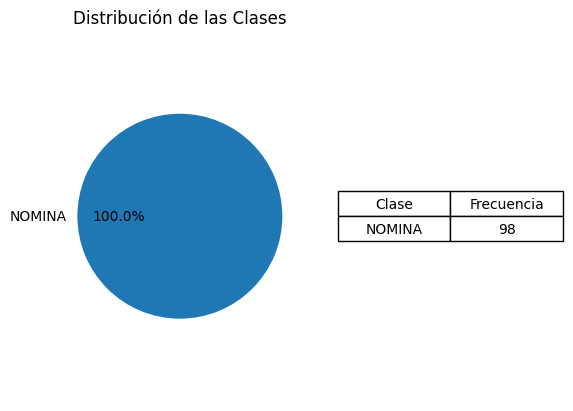

In [ ]:
contar = dataframeFinalhipot['Producto a ofrecer'].value_counts()
# Crear el gráfico de pastel
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.pie(contar.values, labels=list(contar.keys()), autopct='%1.1f%%')
plt.axis('equal')  # Hacer que el gráfico de pastel sea circular
plt.title('Distribución de las Clases')

# Crear la tabla
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
tabla = plt.table(cellText=[[label, value] for label, value in contar.items()],
                  loc='center',
                  cellLoc='center',
                  colLabels=['Clase', 'Frecuencia'])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 1.5)  # Ajustar el tamaño de la tabla
plt.axis('off')  # Desactivar los ejes

plt.show()

#Predicción para los clientes que tienen únicamente el producto **CRED_AUTO**

In [ ]:
datos_auto = datos.loc[(datos['CRED_AUTO'] == 1)
                            & ((datos['NOMINA'] + datos['CRED_HIPOT']
                            + datos['TDC']) > 0)] #obtemos nuestro grupo A_1
                            # lo almacenamos en la variable datos_nomina


datos_perfilauto = datos.loc[((datos['NOMINA'] + datos['CRED_HIPOT']
                          + datos['TDC']) == 0) & (datos['CRED_AUTO'] == 1)]
                          #obtenemos nuestra variabe A_2 y lo almacenamos en datos_perfil

dataframeFinalauto = datos_perfilauto.drop(
    columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])#esta variable almacenará las predicciones
                                                        #y las características  del cliente
productos = ['CRED_HIPOT','TDC','NOMINA']#variable auxiliar para realizar el procedimiento con cada producto

for columna in datos_auto:
    if columna in productos:
        X = datos_auto.drop(columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])#aqui almacenamos las características
        y = datos_auto[columna]#almacenamos la columna del producto en turno (TDC,CRED_HIPOT,CRED_AUTO)

        X_train, X_test, y_train, y_test = train_test_split(
                                                X,
                                                y.values.reshape(-1,1),
                                                train_size   = 0.8,
                                                shuffle      = True
                                            )# dividimos nuestro conjunto,uno para entrenarlo
                                            #y otro para saber el porcentaje de aciertos de nuestro modelo entrenado
        y_train = np.ravel(y_train)#ajusta la forma de los datos para entrenarlos
        modelo_finalauto = RandomForestClassifier(
                        oob_score    = True,
                        n_jobs       = -1,
                        n_estimators = 120,
                        max_features = 2,
                        max_depth   = 3,
                        criterion   = 'gini',
                      ).fit(X_train, y_train)#Entrenamos a nuestros datos con la funcion  RandomForestClassifier

        aciertos = modelo_finalauto.predict(X=X_test) #realizamos las predicciones con el modelo entrenado con
                                                  #el grupo que habíamos separado para saber el %aciertos
        accuracy = accuracy_score(y_true=y_test, y_pred=aciertos, normalize=True)
        print(f"El accuracy de test para el producto {columna} es: {100 * accuracy} % \n")#imprimimos el porcentaje de aciertos

        predicciones = modelo_finalauto.predict_proba(
            X=datos_perfilauto.drop(
                columns = ['NOMINA','TDC','CRED_AUTO','CRED_HIPOT'])
            ) #realizamos las predicciones para nuestro grupo A_2 asignandole una probabilidad
        dataframeFinalauto['Probabilidad '+columna]= predicciones[:,1] #almacenamos las predicciones del producto en turno

dataframeFinalauto['Producto a ofrecer'] = dataframeFinalauto[['Probabilidad NOMINA', 'Probabilidad TDC', 'Probabilidad CRED_HIPOT']].idxmax(axis=1)
dataframeFinalauto['Producto a ofrecer'] = dataframeFinalauto.apply(lambda row: 'NOMINA' if row['Producto a ofrecer'] == 'Probabilidad NOMINA'
                                                            else('TDC' if row['Producto a ofrecer'] == 'Probabilidad TDC'
                                                            else 'CRED_HIPOT'), axis=1)#columna para registrar el producto que se debe ofrecer segun su probabilidad

dataframeFinalauto.head()

El accuracy de test para el producto NOMINA es: 79.38144329896907 % 

El accuracy de test para el producto TDC es: 68.04123711340206 % 

El accuracy de test para el producto CRED_HIPOT es: 72.16494845360825 % 



,CLIENTE,EDAD,GENERO,INGRESOS,SCORE_BURO,Probabilidad NOMINA,Probabilidad TDC,Probabilidad CRED_HIPOT,Producto a ofrecer
10,3021,20,0,13981,519.0,0.751127,0.650701,0.267889,NOMINA
51,3093,38,1,28614,753.0,0.765003,0.715537,0.302603,NOMINA
79,3148,53,1,20129,600.0,0.798466,0.708499,0.293824,NOMINA
85,3162,33,1,296880,680.0,0.777432,0.759315,0.319681,NOMINA
176,3348,21,1,7157,644.0,0.722506,0.672018,0.290022,NOMINA


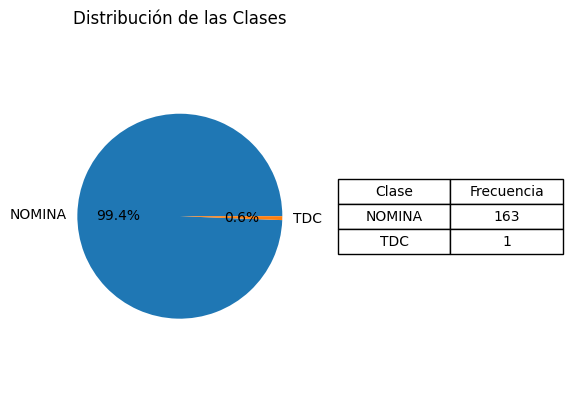

In [ ]:
contar = dataframeFinalauto['Producto a ofrecer'].value_counts()
# Crear el gráfico de pastel
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primer gráfico
plt.pie(contar.values, labels=list(contar.keys()), autopct='%1.1f%%')
plt.axis('equal')  # Hacer que el gráfico de pastel sea circular
plt.title('Distribución de las Clases')

# Crear la tabla
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segundo gráfico
tabla = plt.table(cellText=[[label, value] for label, value in contar.items()],
                  loc='center',
                  cellLoc='center',
                  colLabels=['Clase', 'Frecuencia'])
tabla.auto_set_font_size(False)
tabla.set_fontsize(10)
tabla.scale(1, 1.5)  # Ajustar el tamaño de la tabla
plt.axis('off')  # Desactivar los ejes

plt.show()

#Conclusiones

observemos que en general el producto nómina es el que más se le debería recomendar al cliente,para los casos de los clientes con producto CRED_AUTO y CRED_HIPOT sus características se adaptan al producto NOMINA aunque el producto TDC también sería una opción.

Podemos concluir que el modelo de bosques aleatorios es efectivo para clasificar y realizar predicciones según estas clasificaciones, proporcionando un porcentaje de precisión entre el 70% y el 80%. Además, este porcentaje puede mejorarse aún más al incorporar más características y aumentar el tamaño del conjunto de datos.